In this notebook, we check which of the pairwise splits separate better the 3 clusters.
To that end, we are comparing:
- Sen vs NSen+Basal
- NSen vs Sen+Basal
- Basal vs Sen+NSen

In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
from networkx.algorithms import community
import community
import matplotlib
import itertools
import seaborn as sns
import random

In [2]:
df_filtered = pd.read_csv("df_filteredKS.csv", sep="\t")
df_filtered

geneID    G7F_mean  G7FNSen_mean  G7FSen_mean   G7M_mean  \
0    ENSMUSG00000026154    9.374707     12.772968    27.824232   5.671751   
1    ENSMUSG00000101372    1.444587      1.111497     0.371584   0.699926   
2    ENSMUSG00000026087   22.069027     25.173005    43.724768  16.839861   
3    ENSMUSG00000041763   18.230442     11.950132    12.110390  28.941241   
4    ENSMUSG00000025982  112.095088     84.476640    55.605328  83.438708   
..                  ...         ...           ...          ...        ...   
137  ENSMUSG00000031385    0.000000      0.367214     0.398137   0.000000   
138  ENSMUSG00000002014   36.531070     61.966370    94.802257  64.016520   
139  ENSMUSG00000031198   22.257823     26.709863    36.829580  13.182433   
140  ENSMUSG00000025525    1.787333      2.887403     7.121444   3.833947   
141  ENSMUSG00000025289   64.794850    122.431833   114.343833  50.193153   

     G7MNSen_mean  G7MSen_mean    G7S_mean  G7SNSen_mean  G7SSen_mean  ...  \
0       11.260086    16.675180    0.000000      6.299948    16.657781  ...   
1        0.330705     0.364940    1.624852      0.486327     0.348787  ...   
2       20.386269    26.003121   20.099141     31.424203    30.086606  ...   
3       17.719509    14.524426   27.617458     16.755259    17.023425  ...   
4       65.120788    51.364688  120.530328     74.634990    59.653100  ...   
..            ...          ...         ...           ...          ...  ...   
137      0.000000     0.068053    0.000000      0.000000     1.463048  ...   
138     57.620877    83.569053   31.541450     29.319517    29.808617  ...   
139     13.808850    21.667137    8.334765     25.366677    35.125597  ...   
140      3.837358     8.342085    3.408360      8.749270    17.766763  ...   
141     44.132810    48.840410   23.275993     53.697473    72.309847  ...   

     G3SSen_mean   Y3F_mean  Y3FNSen_mean  Y3FSen_mean   Y3M_mean  \
0      45.174186  21.242280     26.628339    33.862152  21.526737   
1       0.114060   0.582884      0.373457     0.367516   0.367600   
2      32.878457  19.962933     27.788901    33.128654  15.660406   
3      11.825596  12.635614     12.746935    11.025465  15.401941   
4      40.601267  87.341269     63.008648    46.958564  61.851565   
..           ...        ...           ...          ...        ...   
137     0.326122   0.000000      0.263454     0.184928   0.000000   
138    85.980737  61.723820    126.512300   155.044933  50.799810   
139    38.596550  38.528550     35.038627    39.704690  20.947253   
140    18.968587   2.519863     12.714293     8.579726   4.221943   
141   131.150733  73.851210    219.008500   250.300933  53.033977   

     Y3MNSen_mean  Y3MSen_mean  Y3SNSen_mean  Y3SSen_mean    Y3S_mean  
0       31.649925    47.899333     26.170418    48.272665    4.519765  
1        0.055509     0.210572      0.539133     0.318045    1.040053  
2       23.192990    32.742092     38.338612    40.461611   11.934976  
3       12.587769    12.309141     21.549588    12.849492   28.855441  
4       74.434975    44.904032     61.191470    50.753543  147.272977  
..            ...          ...           ...          ...         ...  
137      0.000000     0.273452      0.000000     0.247827    0.000000  
138     55.415170    88.717490     31.050667    58.336110   26.443985  
139     17.393723    43.456097     34.126103    43.358643    7.465416  
140      4.453317    18.298710     18.434093    41.276830    3.720032  
141     27.535113    93.463507     84.721693    89.640110   49.543635  

[142 rows x 37 columns]

In [3]:
def select_cell_type(df, cell_type = "all"):
    """
    Function that inputs a dataframe and selects cell types according to the input string.
       The input strings can be:
       1. "F" for selecting only FAP cells 
       2. "M" for selecting only Macrophage cells
       3. "S" for selecting only Satellite cells
       3. "all" for selecting all cell types
       Finally, it stores the df into a dataframe named df_output.
    """

    
    if cell_type == "F":
        df_output = df.filter(regex='F|geneID')    
    if cell_type == "M":
        df_output = df.filter(regex='M|geneID')
    if cell_type == "S":
        lst = list(df.filter(regex = 'F|M').columns)
        df_output = df[df.columns.difference(lst)]
        first_col = df_output.pop('geneID')
        df_output.insert(0, 'geneID', first_col)
    if cell_type == "all":
        df_output = df
        
    return df_output

In [4]:
def df_processing(import_file, parent_directory, cell_type_separate, norm = False, cell_type = 'all'):
    """
    Function that inputs a dataframe of format: rows = genes, columns = cell conditions
    and outputs a df of format: rows = cell conditions, columns = genes 
    that has standarized gene expression values between [0,1] if norm is set to TRUE.
    Also, it adds a class column where a class is indicated as 1 depending on which 
    cell_type_separate is chosen. For example iscell_type_separate is set to "Bas" the separation
    is done by setting Basal cells to 1 and NSen&Sen to 0.
    
    This formatting is necessary because this is the format that is required by 
    the MATLAB ECFS algorithm.The filename variable will be the name of the file to export.
    """
    import pandas as pd
    df = pd.read_csv(import_file, sep="\t")
    df = select_cell_type(df, cell_type)
    
    #0. extracting gene_id and values in different dataframes
    df_geneid = df["geneID"]
    df_geneid = df_geneid.to_frame().reset_index(drop=True)
    df_values = df.drop(["geneID"], axis=1)
    
    #1. standardization of rows in range [0,1] and keeping column names if norm is set tu TRUE    
    if norm == True:
        norm = 'normalized'
        import pandas as pd
        from sklearn import preprocessing

        #x = df_values.values #returns a numpy array
        x = preprocessing.minmax_scale(df_values.values.T).T
        df_norm = pd.DataFrame(x, columns = df_values.columns)
    
        #min_max_scaler = preprocessing.MinMaxScaler()
        #x_scaled = min_max_scaler.fit_transform(x)
        #df_norm = pd.DataFrame(x_scaled, columns = df_values.columns)
        df_standard = df_geneid.join(df_norm)
    else:
        norm = ''
        df_standard = df
 
    #2. transposing dataframe
    df_transposed = df_standard.T
    header_row = "geneID"
    df_transposed.columns = df_transposed.iloc[0]
    df_transposed = df_transposed.reset_index(drop=False)
    df_transposed = df_transposed.rename(columns={"index": "type"})
    df_transposed = df_transposed.drop([0])
    
    #3. adding class label to the dataframe
    df_class = df_transposed 
    if cell_type_separate == "NSen":
        df_class['class'] = [1 if ("NSen" in x) else 0 for x in df_class['type']]
    if cell_type_separate == "Sen":
        df_class['class'] = [0 if (("NSen" in x) or ("M_" in x) or ("S_" in x) or ("F_" in x)) else 1 for x in df_class['type']]
    if cell_type_separate == "Bas":
        df_class['class'] = [1 if (len(x)==8) else 0 for x in df_class['type']]

    df_class.reset_index()
    dataframe = df_class
    df_export = df_class.drop(['type'], axis = 1)
    
    #putting the new file and import file in the created folder
    import os
    directory = str(import_file) + "_" + cell_type_separate + "_ECFS_protocol"  
    path = os.path.join(parent_directory, directory)
    os.makedirs(path)
    filename = import_file[:-4] +'_'  + cell_type_separate +  "_geneset" + '_' + str(cell_type) + norm +".csv"
    export_file = os.path.join(path, filename)
    df_export.to_csv(export_file, sep='\t')
    
    
    path_import_file = os.path.join(path, import_file)
    df.to_csv(path_import_file, sep='\t', index=False)
        
    return df_export

In [5]:
def ranking_export(filename, df):
    """
    Function that imports the filename with the ranking in the MATLAB format and the 
    respective dataframe that was used for getting the MATLAB format and exports the ranking.
    It outputs the dictionary of the ranking in format: 'geneID'--> 'ranking'
    """
    
    #import data from excel file
    df_ranking = pd.read_excel(filename, sheet_name='Sheet1')
    
    #get the ranking and subtract 1 because of difference in indexing between Matlab and Python
    order_of_ranking = (df_ranking['r']-1).to_list()
    
    #resetting index to df so that geneID can be recognized
    df = df.reset_index(drop=True)
    #reorder the df by the list of rankings from Matlab
    df_ranked = df.reindex(order_of_ranking)
    print(df_ranked)
    
    #create a list of values from 1 to len(df) to assign the rankings
    list_of_ranks = list(range(len(df)+1))[1:]
    #assign a new column to df_ranked that sotres the actual ranking
    df_ranked['ranking'] = list_of_ranks
    #create a new df that has only the geneID and the ranking
    df_all = df_ranked[['geneID', 'ranking']]
    #convert df_all to dictionary
    dict_all = dict(zip(df_all.geneID, df_all.ranking)) 
    
    return df_ranked, df_all#, dict_all

In [6]:
### The following lines of code generate a directory and files, they already exist, don't execute again

In [7]:
#df142_Sen_vs_BasNSen = df_processing("df_filteredKS.csv", parent_directory = "df_142_Sen_vs_BasNSen", cell_type_separate = "Sen", norm = False, cell_type = "all")

In [8]:
#df142_Bas_vs_SenNSen = df_processing("df_filteredKS.csv", parent_directory = "df_142_Bas_vs_SenNSen", cell_type_separate = "Bas", norm = False, cell_type = "all")

In [9]:
#df142_NSen_vs_BasSen = df_processing("df_filteredKS.csv", parent_directory = "df_142_NSen_vs_BasSen", cell_type_separate = "NSen", norm = False, cell_type = "all")

In [10]:
def correlation(dataframe):
    """
    Function that inputs a dataframe of selected genes and 
        1. computes correlation values between the genes in the dataframe
        2. plots the correlation matrix (heatmap)
        3. plots the correlation histogram
        4. plots the KDE of the correlation histogram
        5. returns a dataframe of format 'node1' 'node2' 'correlation coefficient'
           stored in the 'links' variable   
    """
    
    #Computing correlation
    import seaborn as sns
    corr = dataframe.corr(method='pearson')   
     

    #Decomment for plotting individual heatmaps for the genes
    #fig, ax = plt.subplots(figsize=(25,25))
    #sns.heatmap(corr, 
    #    xticklabels=corr.columns,
    #    yticklabels=corr.columns)
    #plt.title('Correlation matrix', fontsize=70, loc='left', pad=50)
    #plt.show()


    #Correlation histogram
    import itertools
    list2d = corr.values.tolist()
    merged = list(itertools.chain(*list2d))
    
    #Decomment for plotting histograms for the genes
    #fig, ax = plt.subplots(figsize=(9,5))
    #plt.hist(corr)
    #plt.xlabel('Correlation')
    #plt.ylabel('Frequency')
    #plt.show()


    #Decomment for plotting the distributions of correlation values
    #KDE correlation histogram
    #fig, ax = plt.subplots(figsize=(9,5))
    #plt.title('Distribution of correlation values', fontsize = 'small', pad = 20)
    #plt.xlabel('Correlation')
    #plt.ylabel('Density')
    #sns.distplot(merged, kde=True, norm_hist=True, color = 'skyblue')
    #plot_data = sns.distplot(merged).get_lines()[0].get_data()
    #yarray = plot_data[1]
    #xarray = plot_data[0]
    #min_value = np.where(yarray == plot_data[1][60:70].min())
    #minimum = xarray[min_value]
    #threshold = float(minimum)
    #plt.show()
    
    #Transform it in a links data frame (3 columns only):
    links = corr.stack().reset_index()
    links.columns = ['gene1', 'gene2','corr_value']
    return links

In [20]:
def filtered(df,threshold, thr_upper = 1):
    """Generates a data frame from a given dataframe and filters it removing the
    edges with a weight lower than a given threshold.
    Input:  * df: a dataframe containing 3 columns (source node, target node and
            weight) and a row for each edge
            * threshold: minimum weight that an edge has to have to not being filtered.
    Output: * df_filtered: filtered dataframe, has 3 columns, keyed 'gene1', 'gene2' and 'corr_value' and
    a row for each edge.
    """
    #df = pd.read_csv(filename, sep="\t")
    df_filtered=df.loc[ (df['corr_value'] >= threshold) & (df['corr_value'] <= thr_upper) & (df['gene1'] != df['gene2']) ]
    return df_filtered

def network(df):
    """Creates and returns a grap (G) from a dataframe (df) using NetworkX library.
    Input:  * df: dataframe with 3 columns, keyed 'gene1', 'gene2' and 'corr_value' and a row for each
            edge.
    Output: * G: Network graph
    """
    G=nx.from_pandas_edgelist(df, 'gene1', 'gene2', edge_attr = 'corr_value')
    return G

def network_plot(G):
    """Functions that from a given network G, creates the plot representation of this network
    Input:  * G: Network graph
    Output: * network plot
    
    """
    
    pos = nx.spring_layout(G, scale=4)  # double distance between all nodes
    #displacement = displacement - pos / ( k * np.sqrt(nnodes))
    fig, ax = plt.subplots(figsize=(20,20))

    nx.draw(G,pos, with_labels=True, node_color='skyblue', node_size=2000 ,edge_color='grey', alpha=0.8 ,linewidths=0.5, font_size=12)


In [12]:
def louvain(G):
    
    """Implements the Louvain community search algorithm in a graph (G) and returns a
    dictionary of the partitions.
    Input:  * G: a graph generated with NetworkX
    Output: * dic_nodes: a dictionary like {community_number:{'node_1 , ... , node_N'}}
    """

    # Starting with an initial partition of the graph and running the Louvain algorithm for Community Detection
    partition=community.best_partition(G, weight='corr_value') #--> it has to have a weight, otherwise it is just 36 communities (each node is one)    

    values=[partition.get(node) for node in G.nodes()]
    list_com=partition.values()

    # Creating a dictionary like {community_number:list_of_participants}
    dict_nodes={}

    # Populating the dictionary with items
    for each_item in partition.items():
        v= set()
        community_num=each_item[1]
        community_node=each_item[0]
        if community_num in dict_nodes:

            dict_nodes.get(community_num).add(community_node)

        else:
            v.add(community_node)
            dict_nodes.update({community_num:v})

    # Creating a new graph to represent the communities created by the Louvain algorithm
    G_comm=nx.Graph()

    # Populating the data from the node dictionary created earlier
    G_comm.add_nodes_from(dict_nodes)

    # Calculating the total number of communities
    #print("Total number of Communities=", len(G_comm.nodes()))
    return dict_nodes, partition

In [13]:
def plot_communities(G): 
    """
    Function that takes a network, computes the communities and plots them .
    """ 
    dict_nodes,partition = louvain(G) 
    pos = nx.spring_layout(G)
  
    #list of correlation values
    durations = [i['corr_value'] for i in dict(G.edges).values()]
   
    #plotting 
    plt.figure(figsize=(15, 10))
    plt.axis('off')
    nx.draw_networkx_nodes(G, pos, node_size=1800, cmap=plt.cm.RdYlBu, node_color=list(partition.values()))    
    nx.draw_networkx_edges(G, pos, alpha=0.3, edge_color=durations, edge_cmap=plt.cm.Blues, width=2)  
    nx.draw_networkx_labels(G,pos, font_size=7, font_color='black', font_weight='bold', alpha=1.0)
    plt.show()

In [14]:
def network_computing(df):
    """
    Function that inputs a dataframe, removes the geneID/symbol (first column of df) 
    and applies all the necessary functions to find the communities.
    """
    #removing first column from the dataframe (that column contains the symbol/geneID of the gene in the row)
    df = df.iloc[:,1:]
    
    #applying correlation function
    corr_df = correlation(df)
    
    #constructing the network
    G = network(corr_df)
    
    #finding communities
    dict_nodes, partition = louvain(G)
    
    return dict_nodes

In [15]:
def h_value(df, n):
    """
    Function that computes the h-score both cell-type-wise and community wise.
    In the case the number of communities is not 3, the h-score is set to 0.
    """ 

    dataframe = correlation(df) #where df will be a dataframe where there are k selected genes

    G = network(dataframe)
  
    dict_nodes, partition = louvain(G) 
    sen = []
    nsen = []
    bas = []
    H_comms = []    
    
    for comm in dict_nodes.values():

        count_sen = 0
        count_nsen = 0
        count_bas = 0
        
        for string in comm:
            #counting sen cells in each community
            if "FSen" in string:
                count_sen +=1
            elif "SSen" in string:
                count_sen +=1
            elif "MSen" in string:
                count_sen+=1
                
            #counting nsen cells in each community
            elif "FNSen" in string:
                count_nsen +=1
            elif "SNSen" in string:
                count_nsen +=1
            elif "MNSen" in string:
                count_nsen+=1
                
            #counting bas cells in each community
            elif "F_" in string:
                count_bas +=1
            elif "S_" in string:
                count_bas +=1
            elif "M_" in string:
                count_bas +=1
            
        
        #computing entropy celltype-wise
        prob_sen_celltype = count_sen/12
        prob_nsen_celltype = count_nsen/12
        prob_bas_celltype = count_bas/12

        sen.append(prob_sen_celltype)
        nsen.append(prob_nsen_celltype)
        bas.append(prob_bas_celltype)
        
        #computing entropy community-wise
        prob_sen_comm = count_sen/len(comm)
        prob_nsen_comm = count_nsen/len(comm)
        prob_bas_comm = count_bas/len(comm)
        #ensure that no "prob" value is equal to 0, because log(0) is undefined
        if prob_sen_comm == 0:
            pS = 0
        else:
            pS = prob_sen_comm*np.log(prob_sen_comm)
        if prob_nsen_comm == 0:
            pN = 0
        else:
            pN = prob_nsen_comm*np.log(prob_nsen_comm)       
        if prob_bas_comm == 0:
            pB = 0
        else:
            pB = prob_bas_comm*np.log(prob_bas_comm) 
        
        H_comm = -1*(pS+pN+pB) 
    
        #computing entropy community-wise
        #storing entropy values for each community in a list named H_comms
        H_comms.append(H_comm)
    
    
    ncomms = len(dict_nodes)
    H_comm_total = np.sum(H_comms)
    
    #computing the entropy celltype-wise
    H_sen = -sum([p*np.log(p) if p !=0 else 0 for p in sen])
    H_nsen = -sum([p*np.log(p) if p !=0 else 0 for p in nsen])
    H_bas = -sum([p*np.log(p) if p !=0 else 0 for p in bas])
    H_celltype_total = H_sen + H_nsen + H_bas
    
    H_total = H_comm_total + H_celltype_total

    #calculating maximums
    H_celltype_max = -3*np.log(1/12)
    H_comm_max = -3*((1/3)*np.log(1/3))
 
    if ncomms == 3:
        h = (H_celltype_max-H_total)/H_celltype_max
    else:
        h = 0 
    return abs(round(h,4)), len(dict_nodes), dict_nodes 

In [22]:
def selecting_genes(rel_path, n, fig_out):
    """
    Function that perfoms the genes selection and does the NC analysis and H-score evaluation for every geneset,
    starting from the [top1] gene then the [top1,top2], then [top1,top2,top3] and so on.
    
    input: *rel_path:relative path to the directory where the files for the analysis are located
           *n: number of senescent cells considered in computing the H-score (default=12)
           
    output:*fig_out: filename that we want to assign to the output figure
    """

    
    import os
    
    #finding the file with the dataframe for extracting top genes in order
    for file in os.listdir(rel_path):
        if  not file.startswith('.') and not file.endswith("_all.csv") and not file.endswith(".xls") and not file.endswith(".png") and not file.endswith(".svg"):
            df = pd.read_csv(file, sep="\t")
    
    #finding the file with the ranking file from MATLAB
    for file in os.listdir(rel_path):
        if file.endswith(".xls"):
            ranking_filename = file
    
    
    ranking_filename = os.path.join(rel_path, ranking_filename)
    df_ranked, df_all = ranking_export(ranking_filename, df)
    
   
    h_list = []
    genes_list=[]
    n_of_com_list = []
    
    tuple_list = []
    for genes in range (6,143): 
   
      
        df_all["geneID"]#.head(2)
       
        list_of_selected_genes = df_all['geneID'].head(genes).values.tolist()
        df_selected = df[df['geneID'].isin(list_of_selected_genes)]
      
        
        h, number_of_comm, dict_nodes = h_value(df_selected, n)
       
        h_list.append(h)
        genes_list.append(genes)
        n_of_com_list.append(number_of_comm)
        tuple_list.append((genes,round(h,3), dict_nodes, number_of_comm))
    
    max_n_comm = max( n_of_com_list)
    limit_for_plot = max_n_comm + 1
    with sns.plotting_context("notebook", font_scale=1.25):
    
        fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(7, 8))
        color = "tab:red"
        ax1.set_ylabel('h-value', color="black")
        ax1.scatter(genes_list, h_list, color=color)
        ax1.tick_params(axis='y', labelcolor="black")
        ax1.set_ylim([-0.1, 1])
        ax1.set_title("Senescent cell selection performance", pad=15)

        color = '#377eb8'
        ax2.set_ylabel('number of communities', color="black")  # we already handled the x-label with ax1
        ax2.scatter(genes_list, n_of_com_list, color=color)
        ax2.tick_params(axis='y', labelcolor="black")
        ax2.set_xlabel('number of selected genes', labelpad=12)
        ax2.set_ylim([-0.1, limit_for_plot])
        fig.tight_layout()
    
    
    
 
    filename_output_img = os.path.join(rel_path, fig_out)
    plt.savefig(filename_output_img, dpi=300, bbox_inches = "tight")
    plt.show()
    
    #the tuple list should be printed out in form of df--> the only think it should be printed as output
    tuple_df= pd.DataFrame(tuple_list, columns=['num_of_genes', 'h_score', 'comm_structure', 'number_of_comm'])

    return tuple_df, rel_path

                 geneID    G7F_mean  G7FNSen_mean  G7FSen_mean    G7M_mean  \
52   ENSMUSG00000049760   46.335710     70.745623   105.511197   73.150397   
35   ENSMUSG00000021917  110.426833    183.249867   308.180600  139.469500   
28   ENSMUSG00000018102   78.853433    514.927167   751.053233   85.980730   
32   ENSMUSG00000032745   90.116127     61.337457    59.904400   85.903253   
117  ENSMUSG00000030771    0.000000      0.045431     0.214271    0.000000   
..                  ...         ...           ...          ...         ...   
70   ENSMUSG00000032679    0.549420      0.000000     1.651297    0.000000   
108  ENSMUSG00000029838    2.595004     96.135273   189.311323    0.034983   
69   ENSMUSG00000085135    0.000000      0.000000     0.943797    0.000000   
76   ENSMUSG00000036353    0.000000      0.000000     0.157385    0.997339   
17   ENSMUSG00000009185   87.526593     60.003237   386.472767   12.487881   

     G7MNSen_mean  G7MSen_mean   G7S_mean  G7SNSen_mean  G7SSen

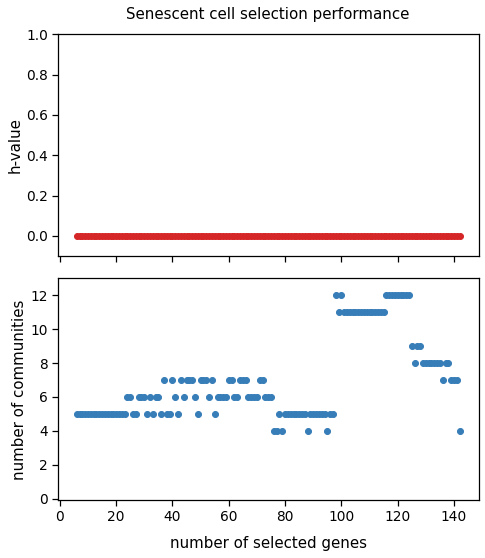

In [23]:
tuple_df_Sen, rel_path = selecting_genes("df_142_Sen_vs_BasNSen/df_filteredKS.csv_Sen_ECFS_protocol", 12, 'hval_communities_Sen.svg')

                 geneID    G7F_mean  G7FNSen_mean  G7FSen_mean    G7M_mean  \
33   ENSMUSG00000021807   39.813933     64.473437    90.809073   36.041583   
106  ENSMUSG00000044471   53.471140     29.909353     7.166949   22.672213   
133  ENSMUSG00000000787  173.575233    133.470933    75.578790   82.104433   
79   ENSMUSG00000028053   18.424960     13.046955     8.329151   12.811153   
58   ENSMUSG00000024360  213.265533    156.301600   124.406433  167.679233   
..                  ...         ...           ...          ...         ...   
113  ENSMUSG00000003363   23.828470     38.747963    71.709857  137.476737   
76   ENSMUSG00000036353    0.000000      0.000000     0.157385    0.997339   
94   ENSMUSG00000028773    1.108826      2.634362     7.292113    1.114405   
17   ENSMUSG00000009185   87.526593     60.003237   386.472767   12.487881   
123  ENSMUSG00000031775    0.000000      0.193750     0.340810    0.000000   

     G7MNSen_mean  G7MSen_mean    G7S_mean  G7SNSen_mean  G7SSe

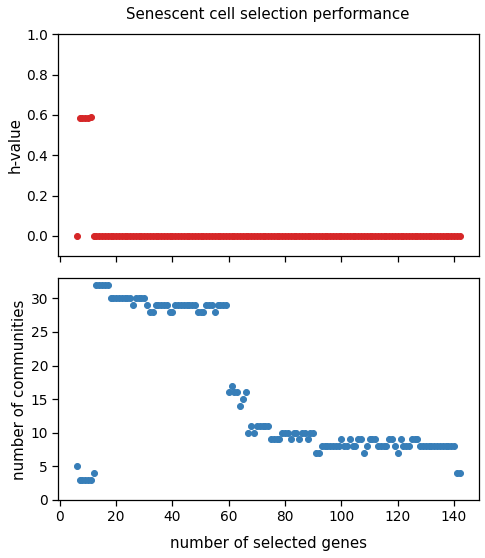

In [24]:
tuple_df_Bas, rel_path = selecting_genes("df_142_Bas_vs_SenNSen/df_filteredKS.csv_Bas_ECFS_protocol", 12, 'hval_communities_Bas.svg')

                 geneID   G7F_mean  G7FNSen_mean  G7FSen_mean   G7M_mean  \
94   ENSMUSG00000028773   1.108826      2.634362     7.292113   1.114405   
10   ENSMUSG00000102433   1.264172      4.773241     5.320926   0.000000   
106  ENSMUSG00000044471  53.471140     29.909353     7.166949  22.672213   
43   ENSMUSG00000071533  10.729073     14.389570     8.495852  10.363422   
18   ENSMUSG00000020863  16.972573     14.361967     8.451580  11.245947   
..                  ...        ...           ...          ...        ...   
140  ENSMUSG00000025525   1.787333      2.887403     7.121444   3.833947   
24   ENSMUSG00000010608  23.077020     20.864160    16.026177  21.245803   
31   ENSMUSG00000021643   1.909945     14.081445    37.102390   2.185018   
114  ENSMUSG00000006315  30.944517     73.472877   123.363850  73.478697   
91   ENSMUSG00000028643  25.712750     28.074680    53.858193  11.353586   

     G7MNSen_mean  G7MSen_mean   G7S_mean  G7SNSen_mean  G7SSen_mean  ...  \
94       0

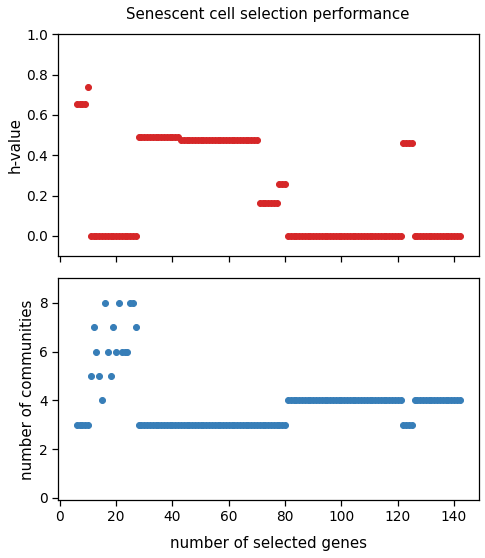

In [25]:
tuple_df_NSen, rel_path = selecting_genes("df_142_NSen_vs_BasSen/df_filteredKS.csv_NSen_ECFS_protocol", 12, 'hval_communities_NSen.svg')

From the plots we can see that the separation that performs best is NSen vs Bas+Sen.

In [26]:
tuple_df_NSen

num_of_genes  h_score                                     comm_structure  \
0               6    0.654  {1: {'Y7S_mean', 'Y3S_mean', 'G3M_mean', 'G7S_...   
1               7    0.654  {1: {'Y7S_mean', 'Y3S_mean', 'G3M_mean', 'G7S_...   
2               8    0.654  {0: {'Y7S_mean', 'Y3S_mean', 'G3M_mean', 'G7S_...   
3               9    0.654  {0: {'Y7S_mean', 'Y3S_mean', 'G3M_mean', 'G7S_...   
4              10    0.737  {0: {'Y7S_mean', 'Y3S_mean', 'G3M_mean', 'G7S_...   
..            ...      ...                                                ...   
132           138    0.000  {3: {'Y7S_mean', 'Y3S_mean', 'Y3MNSen_mean', '...   
133           139    0.000  {3: {'Y7S_mean', 'Y3S_mean', 'Y3MNSen_mean', '...   
134           140    0.000  {3: {'Y7S_mean', 'Y3S_mean', 'Y3MNSen_mean', '...   
135           141    0.000  {2: {'Y7S_mean', 'Y3S_mean', 'Y3MNSen_mean', '...   
136           142    0.000  {3: {'Y7S_mean', 'Y3S_mean', 'Y3MNSen_mean', '...   

     number_of_comm  
0                 3  
1                 3  
2                 3  
3                 3  
4                 3  
..              ...  
132               4  
133               4  
134               4  
135               4  
136               4  

[137 rows x 4 columns]